In [312]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.diagnostic import lilliefors
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb
import warnings

# Base de dados #

In [259]:
warnings.filterwarnings("ignore")

In [260]:
df = pd.read_csv(
    '../data/house/housing.csv', sep = ',',
    encoding = 'iso-8859-1'
)

# Exploração e tratamento dos dados #
**Atributos Previsores**

<span style="font-size: 13px; font-family: Tahoma, sans-serif;">

- RM: é o número médio de cômodos entre os imóveis no bairro. </br>

- LSTAT: é a porcentagem de proprietários no bairro considerados de "classe baixa".

- PTRATIO: é a razão entre estudantes e professores nas escolas de ensino fundamental e médio no bairro.
</span>

**Variável alvo**

- MEDV: valor médio das casas

## Analise de atributos e tipos ##

**Valores missing**

In [261]:
df.isnull().sum()

RM         0
LSTAT      0
PTRATIO    0
MEDV       0
dtype: int64

**Análise dos tipos de atributos**

In [262]:
df.shape

(2340, 4)

In [263]:
df.dtypes

RM         float64
LSTAT      float64
PTRATIO    float64
MEDV       float64
dtype: object

**Dados Estatísticos**

In [264]:
df.describe()

,RM,LSTAT,PTRATIO,MEDV
count,2340.000000,2340.000000,2340.000000,2.340000e+03
mean,6.335303,8.164996,17.729274,5.339491e+05
std,0.493287,5.993575,1.726801,1.493607e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,6.009000,3.740000,16.600000,4.326000e+05
50%,6.335000,5.250000,16.600000,5.250000e+05
75%,6.635000,11.280000,19.200000,6.468000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


## Análise dos outliers ##

**Número médio de cômodos por casa no bairro**

In [265]:
boxplot = px.box(df, y = "RM", width=600, height=400, boxmode='overlay', color_discrete_sequence=["gold"])
boxplot.show()

**Proprietários classe baixa no bairro**

In [266]:
boxplot = px.box(df, y = "LSTAT", width=600, height=400, boxmode='overlay', color_discrete_sequence=["brown"])
boxplot.show()

**Razão entre n. de alunos e professores no bairro**

In [267]:
boxplot = px.box(df, y = "PTRATIO", width=600, height=400, boxmode='overlay', color_discrete_sequence=["red"])
boxplot.show()

**Valor médio das casas**

In [268]:
boxplot = px.box(df, y = "MEDV", width=600, height=400, boxmode='overlay', color_discrete_sequence=["cyan"])
boxplot.show()

## Gráficos de dispersão ##

**Número médio de cômodos por casa no bairro**

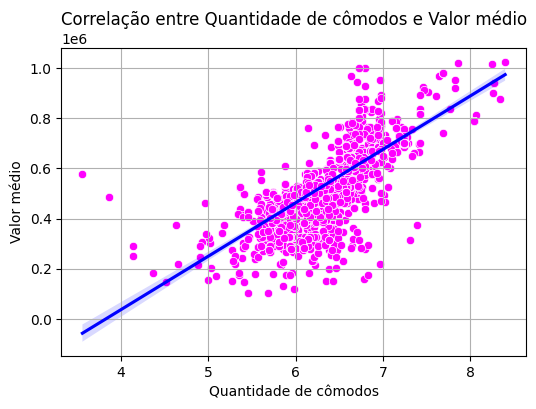

In [269]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="RM", y="MEDV", color='magenta')

sns.regplot(data=df, x="RM", y="MEDV", scatter=False, color='blue')

plt.title('Correlação entre Quantidade de cômodos e Valor médio')
plt.xlabel('Quantidade de cômodos')
plt.ylabel('Valor médio')
plt.grid(True)

plt.show()

**Proprietários classe baixa no bairro**

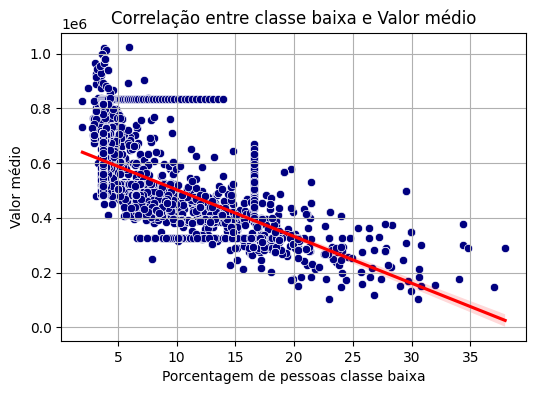

In [270]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="LSTAT", y="MEDV", color='navy')

sns.regplot(data=df, x="LSTAT", y="MEDV", scatter=False, color='red')

plt.title('Correlação entre classe baixa e Valor médio')
plt.xlabel('Porcentagem de pessoas classe baixa')
plt.ylabel('Valor médio')
plt.grid(True)
plt.show()

**Razão entre n. de alunos e professores no bairro**

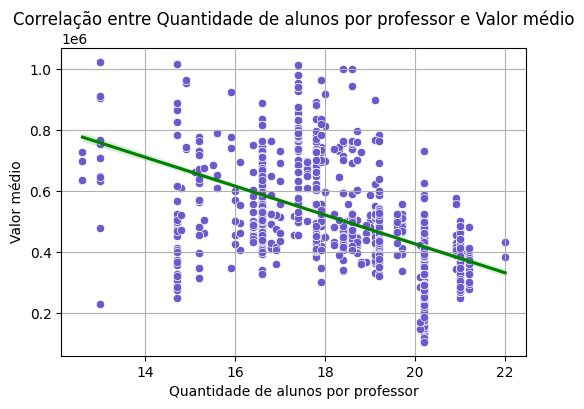

In [271]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df, x="PTRATIO", y="MEDV", color='slateblue')

sns.regplot(data=df, x="PTRATIO", y="MEDV", scatter=False, color='green')

plt.title('Correlação entre Quantidade de alunos por professor e Valor médio')
plt.xlabel('Quantidade de alunos por professor')
plt.ylabel('Valor médio')
plt.grid(True)
plt.show()

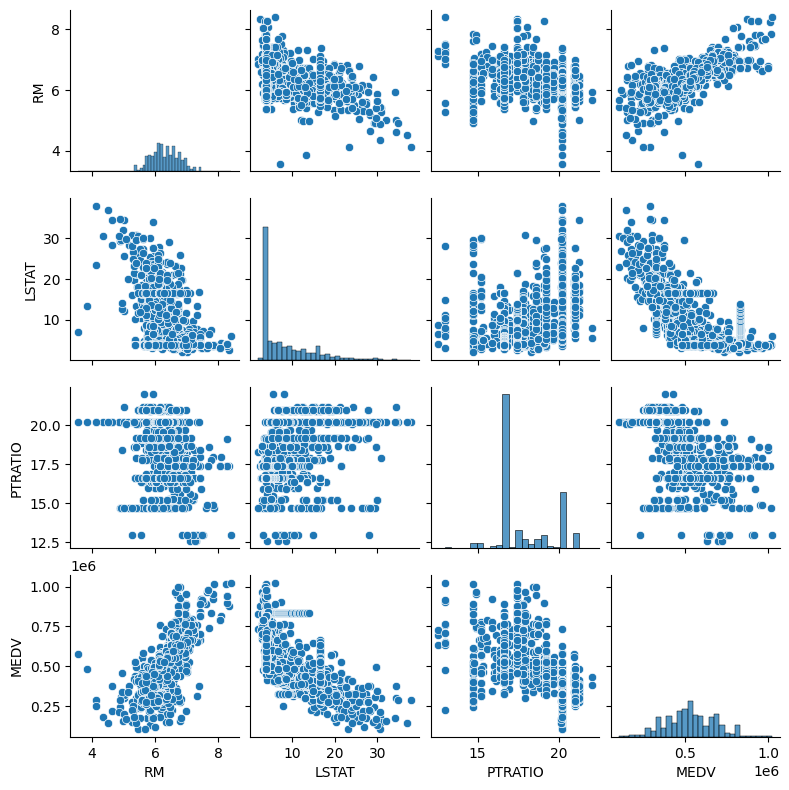

In [272]:
sns.pairplot(df, height=2);

## Análise da Normalidade ##

### Gráfico QQ-Plot ###

**Valor médio das casas no bairro**

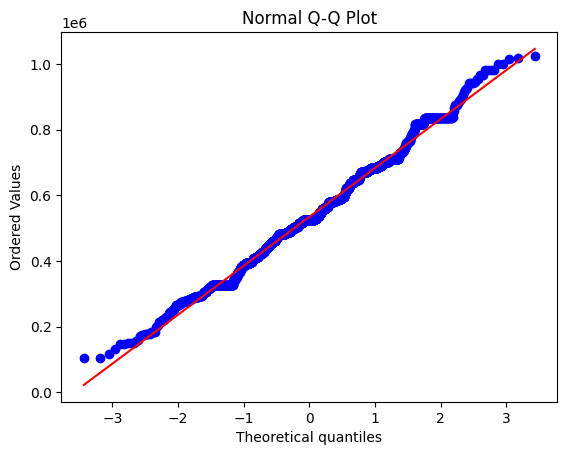

In [273]:
stats.probplot(df['MEDV'], dist = 'norm', plot = plt)
plt.title("Normal Q-Q Plot")
plt.show()

In [274]:
hist = px.histogram(df, x = "MEDV", nbins = 60)
hist.update_layout(width = 600, height = 400, title_text = "Média dos valores")
hist.show()

**Número médio de cômodos por casa**

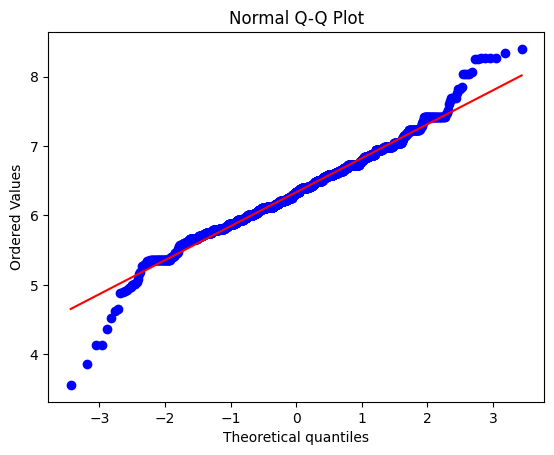

In [275]:
stats.probplot(df['RM'], dist = 'norm', plot = plt)
plt.title("Normal Q-Q Plot")
plt.show()

In [276]:
hist = px.histogram(df, x = "RM", nbins = 60)
hist.update_layout(width = 600, height = 400, title_text = "Cômodos por casa")
hist.show()

**Proprietários classe baixa no bairro**

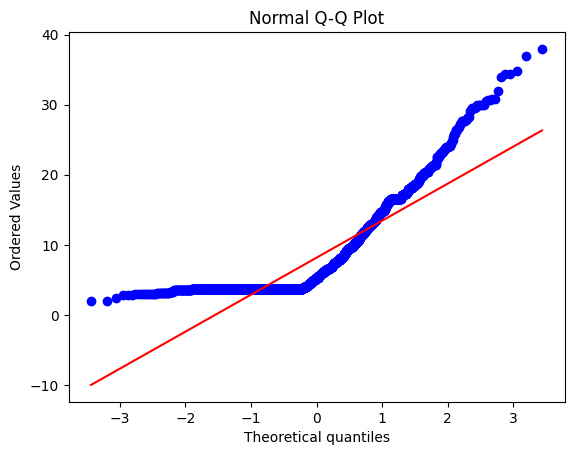

In [277]:
stats.probplot(df['LSTAT'], dist = 'norm', plot = plt)
plt.title("Normal Q-Q Plot")
plt.show()

In [278]:
hist = px.histogram(df, x = "LSTAT", nbins = 60)
hist.update_layout(width = 600, height = 400, title_text = "Porcentagem de pessoas classe baixa")
hist.show()

**Razão entre n. de alunos e professores no bairro**

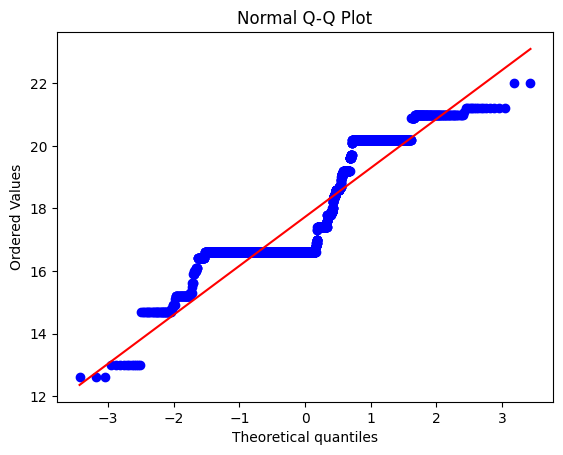

In [279]:
stats.probplot(df['PTRATIO'], dist = 'norm', plot = plt)
plt.title("Normal Q-Q Plot")
plt.show()

In [280]:
hist = px.histogram(df, x = "PTRATIO", nbins = 60)
hist.update_layout(width = 600, height = 400, title_text = "Quantidade de alunos por professor")
hist.show()

## Teste Estatístico ##
<span style="font-size: 14px;">

**HO = Distribuição normal:** p-valor > 0.05 </br></br>
**HA = Distribuição não normal:** p-valor < = 0.05
</span>


**MEDV**

In [281]:
estatistica, p = stats.shapiro(df.MEDV)
print("Estatística do teste: {:.4f}".format(estatistica))
print("p-valor: {:.4e}".format(p))

Estatística do teste: 0.9928
p-valor: 2.4282e-09


In [282]:
estatistica, p = lilliefors(df.MEDV, dist = 'norm')
print("Estatística do teste: {:.4f}".format(estatistica))
print("p-valor: {:.4e}".format(p))

Estatística do teste: 0.0585
p-valor: 1.0000e-03


**RM**

In [283]:
estatistica, p = stats.shapiro(df.RM)
print("Estatística do teste: {:.4f}".format(estatistica))
print("p-valor: {:.4e}".format(p))

Estatística do teste: 0.9827
p-valor: 3.0274e-16


In [284]:
estatistica, p = lilliefors(df.RM, dist = 'norm')
print("Estatística do teste: {:.4f}".format(estatistica))
print("p-valor: {:.4e}".format(p))

Estatística do teste: 0.0425
p-valor: 1.0000e-03


**LSTAT**

In [285]:
estatistica, p = stats.shapiro(df.LSTAT)
print("Estatística do teste: {:.4f}".format(estatistica))
print("p-valor: {:.4e}".format(p))

Estatística do teste: 0.7768
p-valor: 8.2119e-49


In [286]:
estatistica, p = lilliefors(df.LSTAT, dist = 'norm')
print("Estatística do teste: {:.4f}".format(estatistica))
print("p-valor: {:.4e}".format(p))

Estatística do teste: 0.2039
p-valor: 1.0000e-03


**PTRATIO**

In [287]:
estatistica, p = stats.shapiro(df.PTRATIO)
print("Estatística do teste: {:.4f}".format(estatistica))
print("p-valor: {:.4e}".format(p))

Estatística do teste: 0.8185
p-valor: 1.7000e-45


In [288]:
estatistica, p = lilliefors(df.PTRATIO, dist = 'norm')
print("Estatística do teste: {:.4f}".format(estatistica))
print("p-valor: {:.4e}".format(p))

Estatística do teste: 0.3071
p-valor: 1.0000e-03


## Correlação Linear ##

<span style="font-size: 13px;">
<li><strong>Coeficiente de Pearson </strong> -> Distribuição normal</li> </br>
<li><strong>Coeficiente de Spearman</strong> -> Distribuição <strong>não</strong> normal</li></br>
<li><strong>Coeficiente de Kendall</strong> -> Distribuição <strong>não</strong> normal</li>
</span>

**Pearson**

In [289]:
coef, p = stats.pearsonr(df.MEDV, df.RM)
print('Coeficiente de correlação: {:.2f}'.format(coef))
print('p-valor: {:.2e}'.format(p))

Coeficiente de correlação: 0.70
p-valor: 0.00e+00


**Spearman** </br>

*Iremos usá-lo*

<span style="font-size: 13px;"> 
<li>Coeficiente de correlação: 0.73 -> Uma correlação de 0.73 é considerada moderadamente forte.</li> </br>
<li>p-valor: 0.00e+00O -> p-valor gerado é muito baixo e indica que há evidências estatisticamente significativas para rejeitar a hipótese nula de que não há correlação entre as duas variáveis. 
Em outras palavras,<strong> há uma forte correlação entre as variáveis MEDV e RM.</strong> </li>
</span>

In [290]:
coef, p = stats.spearmanr(df.MEDV, df.RM)
print('Coeficiente de correlação: {:.2f}'.format(coef))
print('p-valor: {:.2e}'.format(p))

Coeficiente de correlação: 0.73
p-valor: 0.00e+00


**Kendall**

In [291]:
coef, p = stats.kendalltau(df.MEDV, df.RM)
print('Coeficiente de correlação: {:.2f}'.format(coef))
print('p-valor: {:.2e}'.format(p))

Coeficiente de correlação: 0.53
p-valor: 0.00e+00


In [292]:
correlacoes = df.corr(method = 'spearman')
correlacoes

,RM,LSTAT,PTRATIO,MEDV
RM,1.000000,-0.347137,-0.155367,0.731275
LSTAT,-0.347137,1.000000,0.550828,-0.698332
PTRATIO,-0.155367,0.550828,1.000000,-0.489611
MEDV,0.731275,-0.698332,-0.489611,1.000000


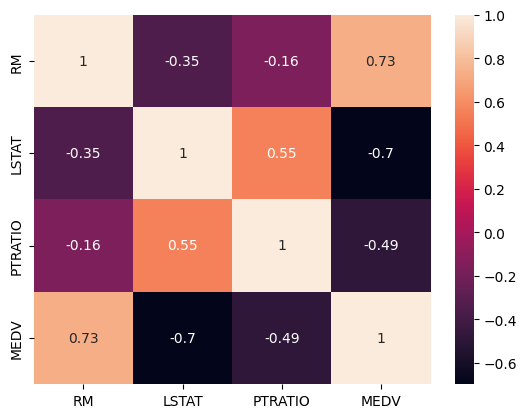

In [293]:
plt.figure()
sns.heatmap(correlacoes, annot = True);

# Regressão XGBOOST #
<span style="font-size: 13px; font-family: Tahoma, sans-serif;">

O XGBoost (Extreme Gradient Boosting) é uma técnica de aprendizado de máquina que pertence à categoria de ensemble learning,</br>
onde múltiplos modelos são combinados para melhorar o desempenho preditivo. Ele é baseado em árvores de decisão</br>
e utiliza um processo de boosting, onde os modelos são construídos sequencialmente, tentando corrigir os erros dos modelos anteriores.

**A fórmula básica para previsão de um modelo XGBoost é dada por:** </br>

$[ \hat{y}_i = \sum_{k=1}^{K} f_k(x_i) ]$

**Onde:** </br>
- $( \hat{y}_i )$ é a previsão para a amostra $( i )$.
- $( K )$ é o número de árvores no modelo.
- $( f_k )$ é a previsão da $( k )$-ésima árvore para a amostra $( i )$.

**Métricas de avaliação:** </br>
- *Erro Quadrático Médio (MSE)* </br>
O Erro Quadrático Médio (MSE) é uma das métricas mais comuns para avaliar modelos de regressão. Ele é calculado como a média dos </br> 
quadrados dos erros entre as previsões do modelo e os valores reais. Quanto menor o valor do MSE, melhor o desempenho do modelo.

- *Coeficiente de Determinação* $(R^2)$ </br>
O Coeficiente de Determinação $(R^2)$ é uma medida estatística que indica a proporção da variância na variável dependente que é explicada</br>
pelas variáveis independentes no modelo. Ele varia de 0 a 1, onde 1 indica um ajuste perfeito do modelo aos dados.</br> 
Um valor próximo de 1 é desejado, indicando que o modelo explica uma grande parte da variabilidade dos dados.

- *Erro Absoluto Médio (MAE)* </br>
O Erro Absoluto Médio (MAE) é a média dos valores absolutos dos erros entre as previsões do modelo e os valores reais.</br> 
Ele fornece uma medida da magnitude média dos erros no modelo. O MAE é menos sensível a valores extremos do que o MSE, pois não eleva os erros ao quadrado.

- *Raiz do Erro Quadrático Médio (RMSE)* </br>
A Raiz do Erro Quadrático Médio (RMSE) é a raiz quadrada do MSE e fornece uma medida do erro médio entre as previsões do modelo</br> 
e os valores reais, na mesma unidade que a variável dependente. Assim como o MSE, quanto menor o valor do RMSE, melhor o desempenho do modelo.

**Parâmetros do XGBoost** </br>
- **n_estimators** </br>
O parâmetro `n_estimators` define o número de árvores a serem criadas no modelo. Um valor maior geralmente leva a um modelo</br> 
mais poderoso, mas também aumenta o tempo de treinamento.

- **max_depth** </br>
O parâmetro `max_depth` controla a profundidade máxima de cada árvore de decisão no modelo. </br>
Profundidades maiores podem levar a modelos mais complexos e propensos a overfitting.

- **learning_rate** </br>
O parâmetro `learning_rate` controla a taxa de aprendizado do modelo, ou seja, a contribuição de cada árvore para a atualização </br>
dos pesos. Um valor menor geralmente resulta em um modelo mais robusto, mas requer mais árvores para alcançar o mesmo desempenho.

- **subsample** </br>
O parâmetro `subsample` controla a fração de observações a serem amostradas para cada árvore. Valores menores podem </br>
ajudar a reduzir o overfitting, mas também podem levar a uma perda de diversidade nas árvores.

- **colsample_bytree** </br>
O parâmetro `colsample_bytree` controla a fração de features a serem amostradas para cada árvore. Isso ajuda a introduzir </br>
mais diversidade nas árvores, reduzindo o overfitting.

</span>

## Tratamento de variáveis 

### Dependente e independente 

In [294]:
indep_x = df.iloc[:, 0:3].values
indep_x

array([[ 6.575,  4.98 , 15.3  ],
       [ 6.421,  9.14 , 17.8  ],
       [ 7.185,  4.03 , 17.8  ],
       ...,
       [ 5.727, 16.6  , 16.6  ],
       [ 6.152, 16.6  , 16.6  ],
       [ 6.289, 16.6  , 16.6  ]])

In [295]:
indep_x.shape

(2340, 3)

In [296]:
depen_y = df.iloc[:, 3].values
depen_y

array([504000., 453600., 728700., ..., 439200., 533400., 529800.])

In [297]:
depen_y.shape

(2340,)

### Separação em treino e teste 

In [298]:
x_train, x_test, y_train, y_test = train_test_split(
    indep_x, depen_y,
    test_size = 0.3, random_state = 0
)

In [299]:
x_train.shape, x_test.shape

((1638, 3), (702, 3))

## Criação do algoritmo 

In [300]:
xgboost = XGBRegressor(
    n_estimators = 120, max_depth = 4,
    learning_rate = 0.04, objective = "reg:squarederror"
)

xgboost.fit(x_train, y_train);

#### Score dos dados de treino

In [301]:
score_train_xg = xgboost.score(x_train, y_train) * 100.0
print('Score Treino: %.2f%%' % score_train_xg)

Score Treino: 92.83%


### Dados de teste

#### Score dos dados de teste

In [302]:
score_test_xg = xgboost.score(x_test, y_test) * 100.0
print('Score Teste: %.2f%%' % score_test_xg)

Score Teste: 90.50%


#### Previsões

In [303]:
previsoes_test_xg = xgboost.predict(x_test)

### Métricas

**Erro médio absoluto**

In [304]:
mean_err_xg = mean_absolute_error(y_test, previsoes_test_xg)
print('{:.2f}'.format(mean_err_xg))

32194.61


**Erro quadrático médio**

In [307]:
mean_sqrt_xg = mean_squared_error(y_test, previsoes_test_xg)
print('{:.2f}'.format(mean_sqrt_xg))

2168150689.70


**Raiz do erro quadrático médio**

In [308]:
np_sqrt_xg = np.sqrt(mean_squared_error(y_test, previsoes_test_xg))
print('{:.2f}'.format(np_sqrt_xg))

46563.41


## Cross validation

In [309]:
kfold = KFold(n_splits = 15, shuffle = True, random_state = 5)

In [310]:
modelo_xg = XGBRegressor(
    n_estimators = 120, max_depth = 4,
    learning_rate = 0.04, objective = "reg:squarederror"
)
resultado_xg = cross_val_score(modelo_xg, indep_x, depen_y, cv = kfold)

In [311]:
print("Acurácia média: %.2f%%" % (resultado_xg.mean() * 100.0))

Acurácia média: 90.24%


# Regressão com Light GBM
<span style="font-size: 13px; font-family: Tahoma, sans-serif;">
O LightGBM é uma técnica de aprendizado de máquina que pertence à categoria de ensemble learning, onde </br>
múltiplos modelos são combinados para melhorar o desempenho preditivo. Assim como o XGBoost, o LightGBM é baseado em árvores</br> 
de decisão e utiliza um processo de boosting, onde os modelos são construídos sequencialmente, tentando corrigir os erros dos modelos anteriores.

**A fórmula básica para previsão de um modelo LightGBM é dada por:** </br>

$[ \hat{y}_i = \sum_{k=1}^{K} f_k(x_i) ]$

**Onde:** </br>
- $( \hat{y}_i )$ é a previsão para a amostra $( i )$.
- $( K )$ é o número de árvores no modelo.
- $( f_k )$ é a previsão da $( k )$-ésima árvore para a amostra $( i )$.

**Métricas de Avaliação:** </br>
- *Erro Quadrático Médio (MSE)*: </br>
O Erro Quadrático Médio (MSE) é uma das métricas mais comuns para avaliar modelos de regressão. </br>
Ele é calculado como a média dos quadrados dos erros entre as previsões do modelo e os valores reais.</br> 
Quanto menor o valor do MSE, melhor o desempenho do modelo.

- *Coeficiente de Determinação $( (R^2) )$*: </br>
O Coeficiente de Determinação $( (R^2) )$ é uma medida estatística que indica a proporção da variância na</br> 
variável dependente que é explicada pelas variáveis independentes no modelo. </br>
Ele varia de 0 a 1, onde 1 indica um ajuste perfeito do modelo aos dados. Um valor próximo de 1 é desejado,</br> 
indicando que o modelo explica uma grande parte da variabilidade dos dados.

- *Erro Absoluto Médio (MAE)*: </br>
O Erro Absoluto Médio (MAE) é a média dos valores absolutos dos erros entre as previsões do modelo e os valores reais.</br> 
Ele fornece uma medida da magnitude média dos erros no modelo. O MAE é menos sensível a valores extremos do que o MSE,</br> 
pois não eleva os erros ao quadrado.

- *Raiz do Erro Quadrático Médio (RMSE)*: </br>
A Raiz do Erro Quadrático Médio (RMSE) é a raiz quadrada do MSE e fornece uma medida do erro médio entre as previsões</br> 
do modelo e os valores reais, na mesma unidade que a variável dependente. Assim como o MSE, quanto menor o valor do RMSE,</br> 
melhor o desempenho do modelo.

**Parâmetros do LIGHT GBM:** </br>
- **num_leaves**: </br>
O parâmetro `num_leaves` controla o número máximo de folhas em cada árvore. </br>
Um valor maior pode levar a um modelo mais complexo e ajustado aos dados, mas também aumenta o risco de overfitting.

- **learning_rate**: </br>
O parâmetro `learning_rate` controla a taxa de aprendizado do modelo, ou seja, a contribuição de cada árvore para a </br>
atualização dos pesos. Um valor menor geralmente resulta em um modelo mais robusto, mas requer mais árvores para alcançar o mesmo desempenho.

- **max_depth**: </br>
O parâmetro `max_depth` controla a profundidade máxima de cada árvore de decisão no modelo. Profundidades maiores podem</br> 
levar a modelos mais complexos e propensos a overfitting.

- **min_child_samples**: </br>
O parâmetro `min_child_samples` especifica o número mínimo de amostras necessárias para formar uma nova folha em uma árvore.</br>
Um valor maior pode ajudar a evitar divisões excessivas que levam ao overfitting.

- **subsample**: </br> 
O parâmetro `subsample` controla a fração de observações a serem amostradas para cada árvore. Valores menores </br>
podem ajudar a reduzir o overfitting, mas também podem levar a uma perda de diversidade nas árvores.

- **colsample_bytree**: </br>
O parâmetro `colsample_bytree` controla a fração de features a serem amostradas para cada árvore. Isso ajuda a </br>
introduzir mais diversidade nas árvores, reduzindo o overfitting.
</span>


## Criando o algoritmo

In [320]:
lgbm = lgb.LGBMRegressor(
    num_leaves = 50, max_depth = 3,
    learning_rate = 0.1, n_estimators = 80,
)
lgbm.fit(x_train, y_train);

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 1638, number of used features: 3
[LightGBM] [Info] Start training from score 533938,514499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

### Score de treino

In [322]:
score_train_lg = lgbm.score(x_train, y_train) * 100.0
print('Score Teste: %.2f%%' % score_train_lg)

Score Teste: 91.06%
